# 랜덤포레스트 회귀

## #01. 패키지

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sb
# 회귀를 위한 더미변수 생성
from pandas import read_excel, DataFrame, get_dummies, to_datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import plot_tree
import dtreeviz

# 
from sklearnex import patch_sklearn
# GPU 사용 가능시
from daal4py.oneapi import sycl_context

## #02. 데이터

> https://www.noaa.gov/

예제에서는 준비된 데이터 사용

- temp2 : 2일전 최대 온도
- temp1 : 1일전 최대 온도
- average : 과거 평균 최대 온도
- actual : 최대온도(종속변수)

In [2]:
origin = read_excel("https://data.hossam.kr/G02/noaa_temp.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB
None


,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [3]:
origin.columns

Index(['year', 'month', 'day', 'week', 'temp_2', 'temp_1', 'average', 'actual',
       'forecast_noaa', 'forecast_acc', 'forecast_under', 'friend'],
      dtype='object')

In [4]:
# 날짜 index 생성
df = origin.copy()
df['date'] = to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)
df.drop(['year', 'month', 'day'], axis=1, inplace=True)
df.head()

,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
date,,,,,,,,,
2016-01-01,Fri,45,45,45.6,45,43,50,44,29
2016-01-02,Sat,44,45,45.7,44,41,50,44,61
2016-01-03,Sun,45,44,45.8,41,43,46,47,56
2016-01-04,Mon,44,41,45.9,40,44,48,46,53
2016-01-05,Tues,41,40,46.0,44,46,46,46,41


In [5]:
df.columns

Index(['week', 'temp_2', 'temp_1', 'average', 'actual', 'forecast_noaa',
       'forecast_acc', 'forecast_under', 'friend'],
      dtype='object')

### 요일에 대한 더미변수 생성

In [6]:
df2 = get_dummies(df, columns=['week'], drop_first=True)
df2.head()

,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
date,,,,,,,,,,,,,,
2016-01-01,45,45,45.6,45,43,50,44,29,False,False,False,False,False,False
2016-01-02,44,45,45.7,44,41,50,44,61,False,True,False,False,False,False
2016-01-03,45,44,45.8,41,43,46,47,56,False,False,True,False,False,False
2016-01-04,44,41,45.9,40,44,48,46,53,True,False,False,False,False,False
2016-01-05,41,40,46.0,44,46,46,46,41,False,False,False,False,True,False


In [7]:
df2.columns

Index(['temp_2', 'temp_1', 'average', 'actual', 'forecast_noaa',
       'forecast_acc', 'forecast_under', 'friend', 'week_Mon', 'week_Sat',
       'week_Sun', 'week_Thurs', 'week_Tues', 'week_Wed'],
      dtype='object')

> 더미변수 'week_Mon', 'week_Sat', 'week_Sun', 'week_Thurs', 'week_Tues', 'week_Wed' 생성

In [8]:
# # 임시코드
# get_dummies(df['week'], drop_first=True).head()

### 독립/종속변수 분할

In [9]:
x = df2.drop('actual', axis=1)
y = df2['actual']
x.shape, y.shape

((348, 13), (348,))

### 훈련/검증 데이터 분할

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((243, 13), (105, 13), (243,), (105,))

## #04. 랜덤포레스트 회귀 모델 구현

### 학습 모델 적합

> GridSearchCV

`cv` : 쪼개는 단위

`n_jobs` : 실행할 병렬 작업의 수. CPU의 프로세스 수만큼 설정 가능. -1은 모든 프로세서를 사용함을 의미.

In [11]:
# 모델 생성
rfc = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=777)

# 사용할 파라미터 설정
params = {
    'random_state':[20,50,],
    "max_depth":[5,30,100]
}

# 모델 생성
grid = GridSearchCV(rfc, param_grid=params, cv=5, n_jobs=-1)
# 학습
grid.fit(x_train, y_train)

print("최적의 하이퍼 파라미터 :",grid.best_params_)
print("최적 훈련 R^2 :",grid.best_score_)

# 예측 값
y_pred = grid.best_estimator_.predict(x_test)
print("최대 검증 R^2 :", r2_score(y_test, y_pred))

# 평균제곱오차
mse = mean_squared_error(y_test, y_pred)
print("MSE :", mse)

최적의 하이퍼 파라미터 : {'max_depth': 5, 'random_state': 20}
최적 훈련 R^2 : 0.8044380864912597
최대 검증 R^2 : 0.8341908917877943
MSE : 22.78224666523154


### 각 변수의 중요도 확인

#### `불순도`

- 클래스가 섞이지 않고 분류가 잘 되었을 수록, 불순도가 낮음
- 클래스가 섞여 있고, 반반인 경우에는, 불순도가 높음
- 의사결정나무 모델은 이 불순도가 낮아지는 방향으로 학습을 진행

#### `지니계수`

- 불순도를 측정하는 지표
- 지니계수는 통계적 분산 정도를 정량화해서 표현한 값, 0과 1사이의 값을 가짐
- 지니계수가 높을 수록 잘 분류되지 못한 것

DecisionTree 모델에서 데이터를 나누는 기준은 `지니계수`이다. DecisionTree 모델에서 중요도는 지니계수가 얼마나 줄어드는지가 기준이 되는 값이다.

Regression 모델의 회귀계수와 달리 항상 양수값을 갖으며, 특성의 모든 특성 불순도를 합치면 1이 된다.

> 회귀분석 모델에서 각 변수의 설명력을 의미하는 것이 아님에 유의.

In [12]:
best_model = grid.best_estimator_
best_model.feature_importances_

array([0.04079705, 0.42824198, 0.26680533, 0.02913249, 0.19212018,
       0.01108184, 0.0174818 , 0.00658405, 0.00102799, 0.00272273,
       0.00090088, 0.00254384, 0.00055985])

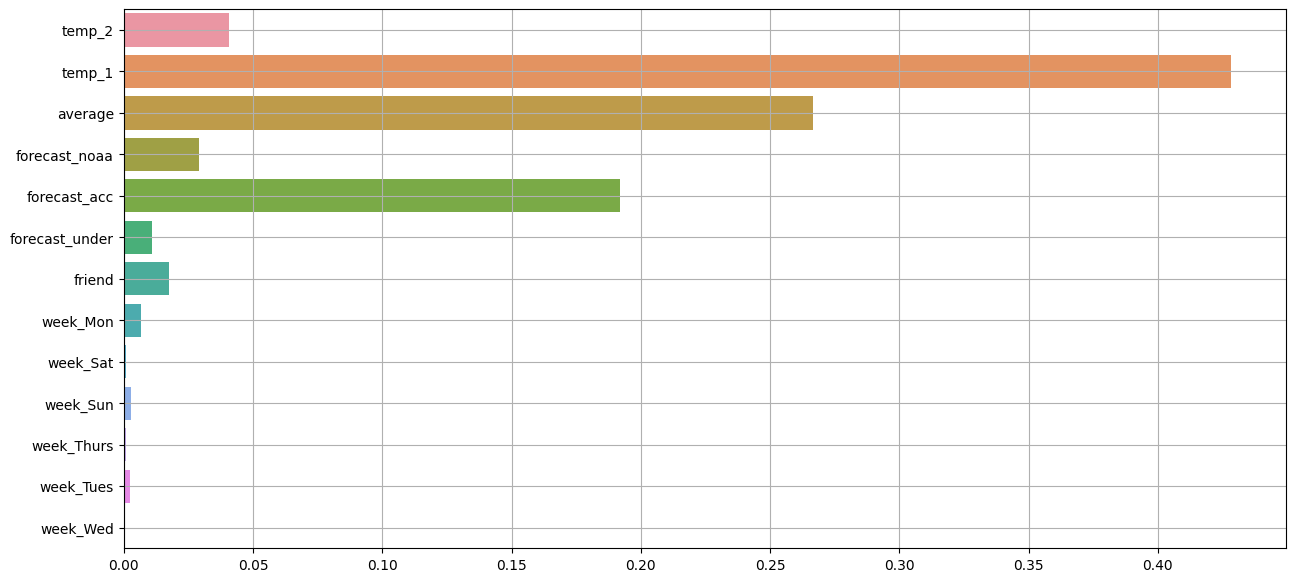

In [13]:
plt.figure(figsize=(15,7))
sb.barplot(y=x_train.columns, x=best_model.feature_importances_)
plt.grid()
plt.show()
plt.close()

### 임의의 단일 트리 확인

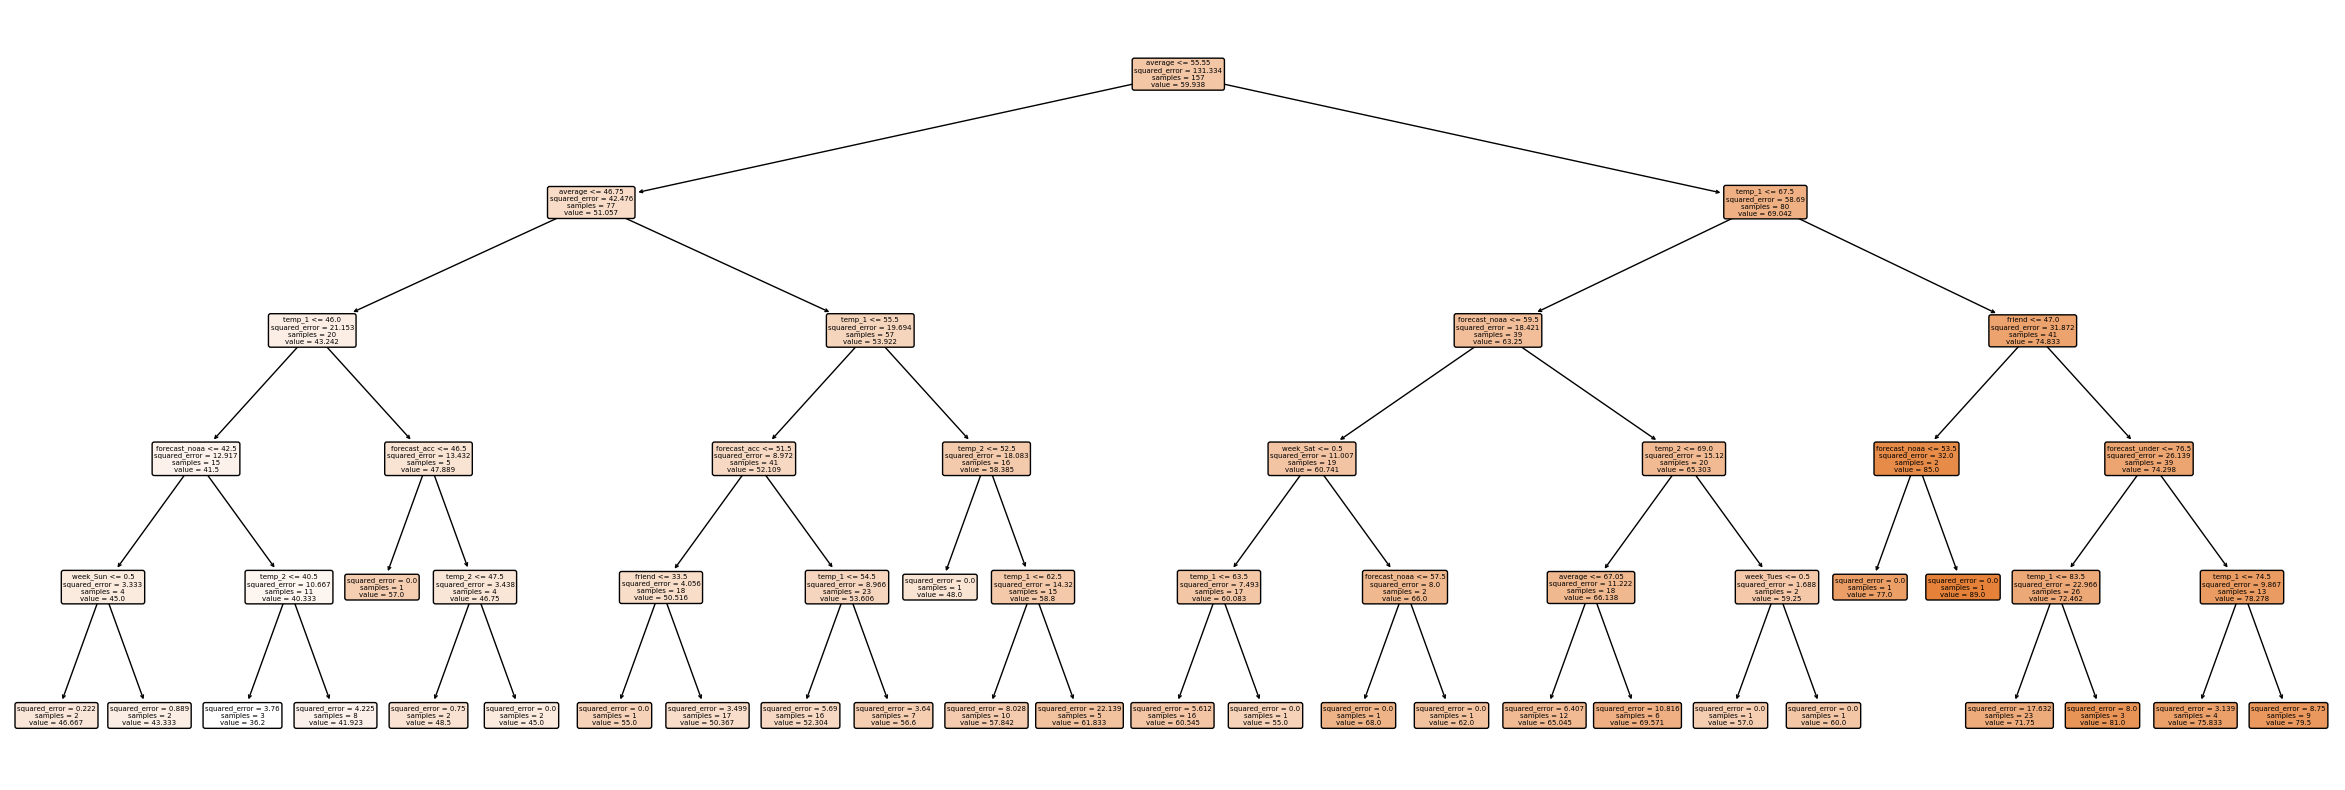

In [14]:
dtree = best_model[0]

plt.figure(figsize=(30, 10))

_ = plot_tree(
    dtree,
    feature_names=list(x_train.columns),
    rounded=True,   # 노드의 모서리를 둥글게
    filled=True # 노드의 색상을 다르게
    )
plt.show()
plt.close()

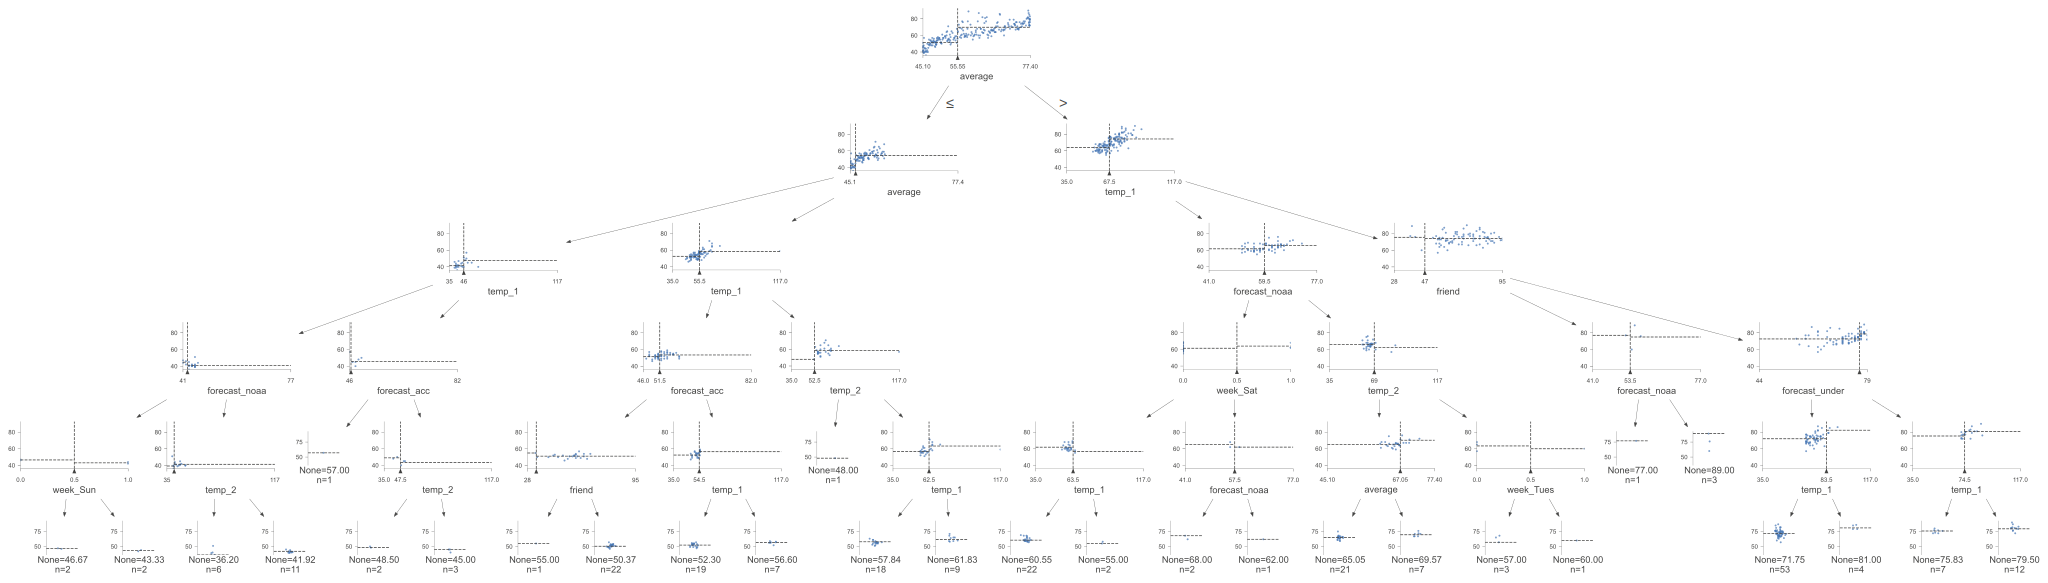

In [15]:
viz = dtreeviz.model(
    dtree,
    X_train=x_train,
    y_train=y_train,
    feature_names=x_train.columns
)
viz.view(scale=2.0)

### 종속변후에 대한 관측치와 예측값 비교

In [ ]:
pred_df = DataFrame({'y_test':y_test, 'y_pred':y_pred})
pred_df.sort_index(inplace=True)
pred_df

In [ ]:
plt.figure(figsize=(15,7))

sb.lineplot(data=pred_df, x=pred_df.index, y='y_test', label='y_test')
sb.lineplot(data=pred_df, x=pred_df.index, y='y_pred', label='y_pred')

plt.grid()
plt.show()
plt.close()